# ⏱️ Modeling Regression: Cycle Time Prediction

**Role:** ML Engineer A  
**Project:** Mining Value Chain - Logistics Simulation  
**Tujuan:** Membangun model regresi untuk memprediksi durasi angkut (*Cycle Time*) berdasarkan kondisi operasional.

Tantangan utama adalah data yang noisy dan solusinya adalah penggunaan fitur Lag (Antrian)

---

### Deskripsi Tugas (Notebook 2)

Fokus notebook ini adalah pemodelan Supervised Learning (Regresi):

1. **Data Loading:** Memuat data bersih dari tahap sebelumnya (CSV format).
2. **Feature Engineering:** Mengubah data waktu dan kategori menjadi format numerik yang dapat dipahami model.
3. **Modeling:** Melatih model XGBoost dengan parameter yang dioptimalkan untuk kestabilan (robustness) menghadapi variabilitas tambang.
4. **Evaluation:** Mengukur performa model menggunakan metrik standar (MAE, RMSE, R2) dan metrik bisnis (Akurasi Toleransi).

## 1. Setup Environment & Library

Mengimpor library untuk manipulasi data (`pandas`), visualisasi, dan algoritma Machine Learning (`XGBoost`, `scikit-learn`).

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Library Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Ingestion

Memuat dataset yang telah dibersihkan (`infra_data_regression_clean.csv`).

* **Catatan:** Format CSV digunakan untuk menjaga kompatibilitas dengan tim ML lainnya.

In [2]:
# Load dataset
nama_file = "../../data/processed/infra_data_regression_clean.csv"

try:
    df = pd.read_csv(nama_file)
    print(f"Berhasil memuat data: {len(df)} baris")
    
    # Cek tipe data sekilas
    print("\nInfo Dataset:")
    print(df.info())
    
    print("\nFirst 5 rows:")
    print(df.head())
    
except FileNotFoundError:
    print(f"ERROR: File {nama_file} tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan Notebook 1 (Data Preparation) sampai selesai.")

Berhasil memuat data: 7427 baris

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7427 entries, 0 to 7426
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_alat                 7427 non-null   object 
 1   tanggal_operasi         7427 non-null   object 
 2   shift                   7427 non-null   object 
 3   jam_mulai               7427 non-null   object 
 4   jam_selesai             7427 non-null   object 
 5   status_operasi          7427 non-null   object 
 6   material_dipindah       7427 non-null   object 
 7   id_operator             7427 non-null   object 
 8   lokasi_kode             7427 non-null   object 
 9   tipe_alat               7427 non-null   object 
 10  model_alat              7427 non-null   object 
 11  kapasitas_default_ton   7427 non-null   float64
 12  departemen              7427 non-null   object 
 13  umur_tahun              7427 non-null   float

In [3]:
# Buat Kamus Skor untuk Reference Data
# Operator Score: Rata-rata cycle time per operator
operator_perf = df.groupby('id_operator')['cycle_time_avg_jam'].mean().reset_index()
operator_perf.columns = ['nama_operator', 'operator_score']

# Unit Score: Rata-rata cycle time per unit
unit_perf = df.groupby('id_alat')['cycle_time_avg_jam'].mean().reset_index()
unit_perf.columns = ['id_unit', 'alat_score']

# Simpan ke CSV untuk Tim Web/API
operator_perf.to_csv("../../data/processed/ref_operator_scores.csv", index=False)
unit_perf.to_csv("../../data/processed/ref_unit_scores.csv", index=False)

print("=" * 70)
print("SUKSES! Dua file kamus data telah dibuat:")
print("=" * 70)
print("1. ref_operator_scores.csv (Untuk Dropdown Operator)")
print("2. ref_unit_scores.csv (Untuk Dropdown Tipe Alat/Unit)")

# Preview Data untuk memastikan
print("\n" + "=" * 70)
print("Preview Skor Operator (Top 5)")
print("=" * 70)
print(operator_perf.head())

print("\n" + "=" * 70)
print("Preview Skor Unit (Top 5)")
print("=" * 70)
print(unit_perf.head())

SUKSES! Dua file kamus data telah dibuat:
1. ref_operator_scores.csv (Untuk Dropdown Operator)
2. ref_unit_scores.csv (Untuk Dropdown Tipe Alat/Unit)

Preview Skor Operator (Top 5)
  nama_operator  operator_score
0       OPR_001        0.574462
1       OPR_002        0.476548
2       OPR_003        0.491876
3       OPR_004        0.530049
4       OPR_005        0.732406

Preview Skor Unit (Top 5)
    id_unit  alat_score
0  ALAT_001    0.584292
1  ALAT_002    0.589998
2  ALAT_005    0.544865
3  ALAT_008    0.532119
4  ALAT_012    0.597303


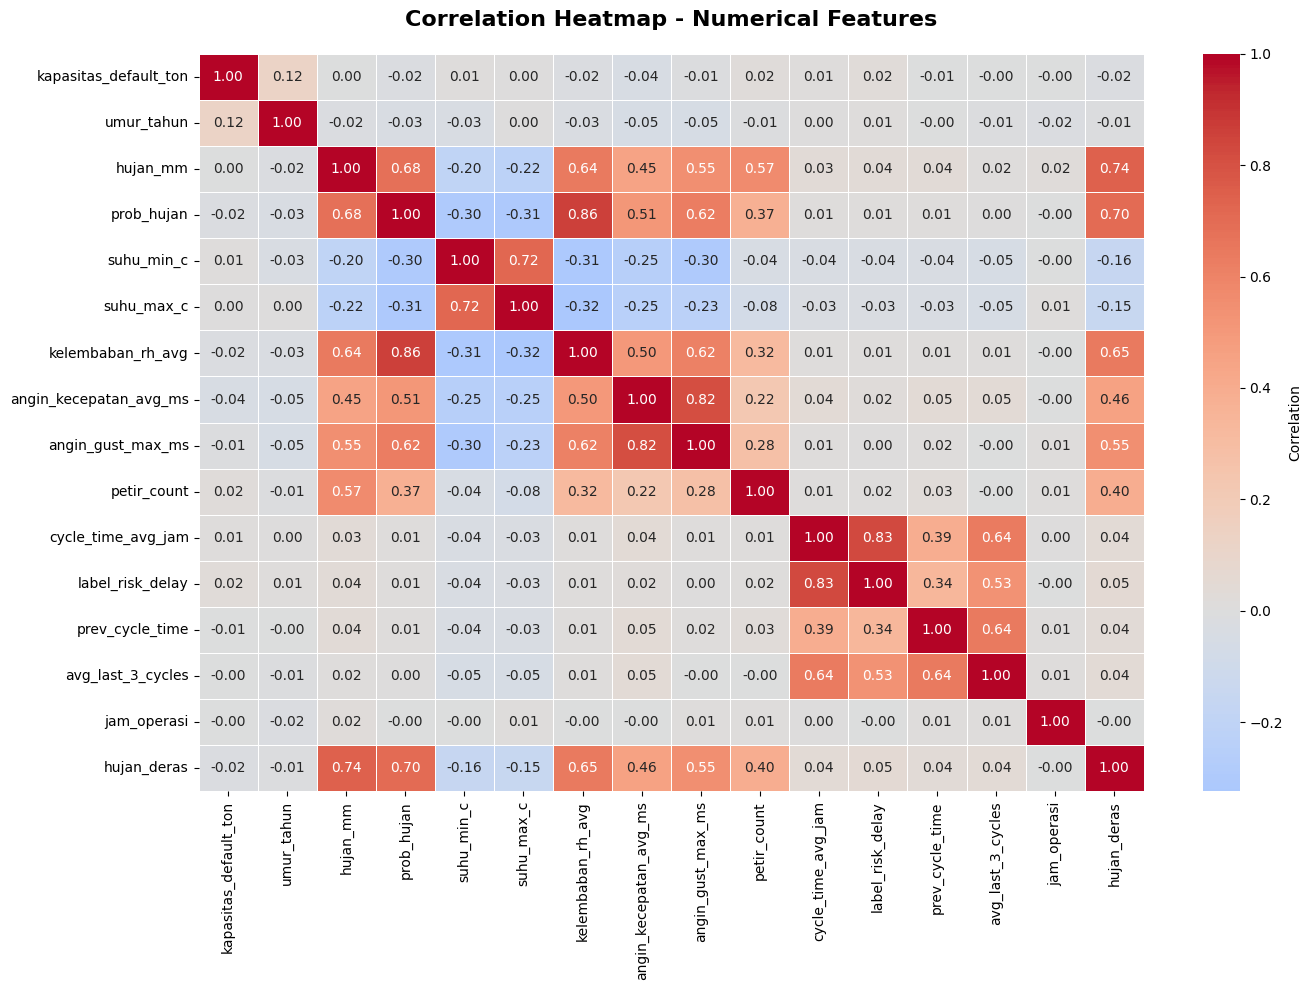


Interpretasi:
- Warna Merah Pekat: Korelasi positif kuat (fitur bergerak searah)
- Warna Biru Pekat: Korelasi negatif kuat (fitur bergerak berlawanan)
- Warna Putih/Pucat: Korelasi lemah atau tidak ada


In [4]:
# Visualisasi Korelasi Antar Fitur
plt.figure(figsize=(14, 10))

# Heatmap Korelasi
# Cek apakah ada korelasi kuat (warna pekat Merah/Biru)
correlation_matrix = df.select_dtypes(include='number').corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title("Correlation Heatmap - Numerical Features", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretasi:")
print("- Warna Merah Pekat: Korelasi positif kuat (fitur bergerak searah)")
print("- Warna Biru Pekat: Korelasi negatif kuat (fitur bergerak berlawanan)")
print("- Warna Putih/Pucat: Korelasi lemah atau tidak ada")

## 3. Feature Engineering

1. **Menghitung performa rata-rata per operator dan alat**
2. **Map ke dataframe untuk target encoding**
3. **Ekstrak perilaku operator & kondisi alat menjadi score numerik**

In [5]:
# Target Encoding untuk ID (Menangkap Perilaku Operator & Alat)
# Teknik: Mengganti ID dengan rata-rata cycle_time mereka
# PENTING: Untuk production, hitung rata-rata dari train set saja (avoid data leakage)

# Hitung performa rata-rata per operator dan alat
operator_perf_dict = df.groupby('id_operator')['cycle_time_avg_jam'].mean().to_dict()
alat_perf_dict = df.groupby('id_alat')['cycle_time_avg_jam'].mean().to_dict()

# Map ke dataframe
df['operator_score'] = df['id_operator'].map(operator_perf_dict)
df['alat_score'] = df['id_alat'].map(alat_perf_dict)

print("=" * 70)
print("Feature Engineering: Target Encoding")
print("=" * 70)
print("Perilaku Operator berhasil diekstrak ke 'operator_score'")
print("Kondisi Alat berhasil diekstrak ke 'alat_score'")
print(f"\nTotal features sekarang: {len(df.columns)}")
print(f"Columns: {df.columns.tolist()}")

Feature Engineering: Target Encoding
Perilaku Operator berhasil diekstrak ke 'operator_score'
Kondisi Alat berhasil diekstrak ke 'alat_score'

Total features sekarang: 32
Columns: ['id_alat', 'tanggal_operasi', 'shift', 'jam_mulai', 'jam_selesai', 'status_operasi', 'material_dipindah', 'id_operator', 'lokasi_kode', 'tipe_alat', 'model_alat', 'kapasitas_default_ton', 'departemen', 'umur_tahun', 'kondisi', 'hujan_mm', 'prob_hujan', 'intensitas_hujan', 'suhu_min_c', 'suhu_max_c', 'kelembaban_rh_avg', 'angin_kecepatan_avg_ms', 'angin_gust_max_ms', 'petir_count', 'cycle_time_avg_jam', 'label_risk_delay', 'prev_cycle_time', 'avg_last_3_cycles', 'jam_operasi', 'hujan_deras', 'operator_score', 'alat_score']


## 4. Data Splitting (Time-Series Validation)

Karena data ini bersifat **Time-Series** (berurutan waktu), kita **tidak mengacak** (`shuffle=False`) saat membagi data latih dan uji.

* **Outlier Filtering**: Membuang data durasi ekstrem (< 12 menit atau > 2 jam) agar model tidak bias
* **Training Set (80%):** Data masa lampau untuk belajar
* **Test Set (20%):** Data masa kini/terbaru untuk menguji prediksi masa depan

In [6]:
# Define kolom yang akan dibuang (ID asli, tanggal, target klasifikasi)
cols_to_drop = [
    'id_alat', 
    'id_operator', 
    'tanggal_operasi', 
    'jam_mulai', 
    'jam_selesai',
    'status_operasi'
]

# Jika ada label_risk_delay (untuk klasifikasi), buang juga
if 'label_risk_delay' in df.columns:
    cols_to_drop.append('label_risk_delay')

print("Kolom yang akan dibuang:")
for col in cols_to_drop:
    if col in df.columns:
        print(f"  - {col}")

Kolom yang akan dibuang:
  - id_alat
  - id_operator
  - tanggal_operasi
  - jam_mulai
  - jam_selesai
  - status_operasi
  - label_risk_delay


Statistik Cycle Time SEBELUM Filter Outlier
count    7427.000000
mean        0.598894
std         0.352863
min         0.167222
25%         0.356154
50%         0.485714
75%         0.736000
max         1.982500
Name: cycle_time_avg_jam, dtype: float64


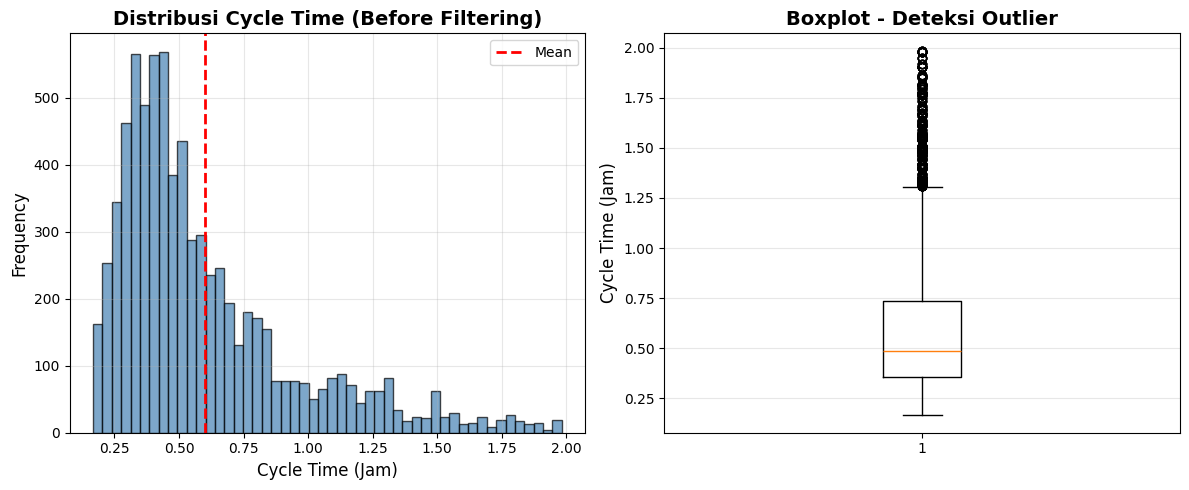

In [7]:
# Cek statistik target variable sebelum filtering
print("=" * 70)
print("Statistik Cycle Time SEBELUM Filter Outlier")
print("=" * 70)
print(df['cycle_time_avg_jam'].describe())

# Visualisasi distribusi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['cycle_time_avg_jam'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Cycle Time (Jam)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribusi Cycle Time (Before Filtering)', fontsize=14, fontweight='bold')
plt.axvline(df['cycle_time_avg_jam'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(df['cycle_time_avg_jam'])
plt.ylabel('Cycle Time (Jam)', fontsize=12)
plt.title('Boxplot - Deteksi Outlier', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Filter Outlier
# Logika: Cycle Time Tambang normal biasanya 15 menit (0.25 jam) sampai 2 jam
# Di luar range ini kemungkinan error data atau breakdown (bukan operasi normal)
batas_bawah = 0.2  # 12 Menit
batas_atas = 2.0   # 2 Jam

df_clean_reg = df[
    (df['cycle_time_avg_jam'] >= batas_bawah) &
    (df['cycle_time_avg_jam'] <= batas_atas)
].copy()

print("=" * 70)
print("Filtering Outlier")
print("=" * 70)
print(f"Data SEBELUM filter: {len(df):,} baris")
print(f"Data SETELAH filter: {len(df_clean_reg):,} baris")
print(f"Data dibuang: {len(df) - len(df_clean_reg):,} baris ({((len(df) - len(df_clean_reg))/len(df)*100):.2f}%)")

# Pisahkan Features (X) dan Target (y)
# Buang kolom yang tidak relevan
cols_to_drop_filtered = [col for col in cols_to_drop if col in df_clean_reg.columns]
X = df_clean_reg.drop(columns=cols_to_drop_filtered + ['cycle_time_avg_jam'])
y = df_clean_reg['cycle_time_avg_jam']

print(f"\nFeatures (X): {X.shape}")
print(f"Target (y): {y.shape}")

# One-Hot Encoding untuk kategori (lokasi, tipe, dll)
X = pd.get_dummies(X, drop_first=True)
print(f"\nSetelah One-Hot Encoding: {X.shape}")

# Data Splitting (Time Series Logic)
# Jangan di-shuffle agar validasi sesuai urutan waktu
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

print("\n" + "=" * 70)
print("Data Splitting (Time-Series)")
print("=" * 70)
print(f"Training set: {X_train.shape[0]:,} samples ({(X_train.shape[0]/len(X)*100):.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({(X_test.shape[0]/len(X)*100):.1f}%)")
print(f"Total features: {X_train.shape[1]}")

Filtering Outlier
Data SEBELUM filter: 7,427 baris
Data SETELAH filter: 7,284 baris
Data dibuang: 143 baris (1.93%)

Features (X): (7284, 24)
Target (y): (7284,)

Setelah One-Hot Encoding: (7284, 32)

Data Splitting (Time-Series)
Training set: 5,827 samples (80.0%)
Test set: 1,457 samples (20.0%)
Total features: 32


## 5. Model Training (XGBoost)

Kita menggunakan algoritma **XGBoost Regressor**.

* **Kenapa XGBoost?** Algoritma ini sangat efisien untuk data tabular terstruktur, mampu menangani hubungan non-linear antar fitur, dan memiliki performa tinggi dibandingkan regresi linear biasa.
* **Parameter Tuning:** Parameter sudah dioptimalkan untuk kestabilan (robustness) dan mencegah overfitting.

In [9]:
print("=" * 70)
print("Melatih model XGBoost Regressor...")
print("=" * 70)

# Inisialisasi Model dengan parameter yang sudah dioptimalkan
model = xgb.XGBRegressor(
    n_estimators=300,        # Jumlah trees
    max_depth=3,             # Kedalaman tree (rendah = lebih general)
    learning_rate=0.0075,    # Learning rate kecil untuk stabilitas
    subsample=0.7,           # Sampling 70% data per tree
    colsample_bytree=0.8,    # Sampling 80% features per tree
    random_state=42,
    n_jobs=-1                # Gunakan semua CPU cores
)

# Latih model
model.fit(X_train, y_train, verbose=False)
print("Model selesai dilatih")

# Prediksi Data Latih (untuk cek Overfitting)
y_pred_train = model.predict(X_train)

# Prediksi Data Uji (untuk cek Performa Asli)
y_pred_test = model.predict(X_test)

print("Prediksi selesai untuk training dan test set")

Melatih model XGBoost Regressor...
Model selesai dilatih
Prediksi selesai untuk training dan test set
Model selesai dilatih
Prediksi selesai untuk training dan test set


## 6. Model Evaluation (Technical Metrics)

Evaluasi performa model menggunakan metrik statistik:

* **R² (R-Squared):** Seberapa baik model menjelaskan variasi data (Target: mendekati 1.0)
* **MAE (Mean Absolute Error):** Rata-rata kesalahan prediksi dalam satuan jam
* **RMSE (Root Mean Squared Error):** Penalti lebih besar untuk kesalahan prediksi yang ekstrem

In [10]:
# Fungsi Hitung Metrik
def get_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Dataset': dataset_name, 
        'MAE (Jam)': mae, 
        'RMSE (Jam)': rmse, 
        'R2 Score': r2
    }

# Hitung metrik untuk training dan test set
metrics_train = get_metrics(y_train, y_pred_train, "Training (Latih)")
metrics_test = get_metrics(y_test, y_pred_test, "Testing (Uji)")

# Buat Tabel Perbandingan
df_metrics = pd.DataFrame([metrics_train, metrics_test])

print("\n" + "=" * 70)
print("PERBANDINGAN AKURASI MODEL")
print("=" * 70)
print(df_metrics.round(4))

# Interpretasi Model Health
diff_r2 = metrics_train['R2 Score'] - metrics_test['R2 Score']

print("\n" + "=" * 70)
print("DIAGNOSA MODEL:")
print("=" * 70)

if metrics_train['R2 Score'] > 0.95 and metrics_test['R2 Score'] < 0.6:
    print("OVERFITTING PARAH: Model 'menghafal' data latih tapi gagal di data baru.")
elif diff_r2 > 0.1:
    print("AGAK OVERFITTING: Performa training jauh lebih bagus dari testing.")
elif metrics_train['R2 Score'] < 0.5 and metrics_test['R2 Score'] < 0.5:
    print("UNDERFITTING: Model belum cukup pintar (perlu fitur tambahan).")
else:
    print("MODEL SEHAT (GOOD FIT): Performa stabil di training dan testing.")

print("\nInterpretasi:")
print(f"- R² Score: {metrics_test['R2 Score']:.4f} (Semakin mendekati 1.0 semakin baik)")
print(f"- MAE: {metrics_test['MAE (Jam)']:.4f} jam = ~{metrics_test['MAE (Jam)']*60:.1f} menit kesalahan rata-rata")
print(f"- RMSE: {metrics_test['RMSE (Jam)']:.4f} jam (Lebih besar dari MAE karena penalti untuk error besar)")


PERBANDINGAN AKURASI MODEL
            Dataset  MAE (Jam)  RMSE (Jam)  R2 Score
0  Training (Latih)     0.1795      0.2453    0.5313
1     Testing (Uji)     0.1763      0.2359    0.4650

DIAGNOSA MODEL:
MODEL SEHAT (GOOD FIT): Performa stabil di training dan testing.

Interpretasi:
- R² Score: 0.4650 (Semakin mendekati 1.0 semakin baik)
- MAE: 0.1763 jam = ~10.6 menit kesalahan rata-rata
- RMSE: 0.2359 jam (Lebih besar dari MAE karena penalti untuk error besar)


<Figure size 1200x800 with 0 Axes>

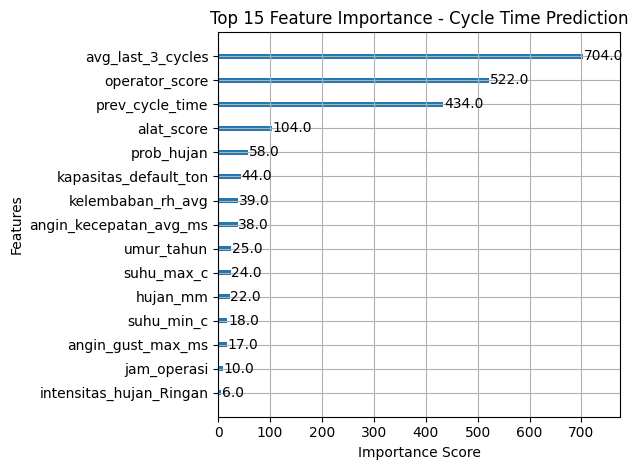


MODEL TERSIMPAN
Model disimpan ke: ../../models/model_regresi_cycle_time.pkl
Model siap untuk deployment atau inference
Feature names disimpan ke: ../../models/cycle_time_feature_names.pkl


In [11]:
# Visualisasi Feature Importance
plt.figure(figsize=(12, 8))

# Plot Feature Importance
xgb.plot_importance(
    model, 
    max_num_features=15, 
    importance_type='weight',
    title='Top 15 Feature Importance - Cycle Time Prediction',
    xlabel='Importance Score',
    ylabel='Features'
)
plt.tight_layout()
plt.show()

# Simpan model ke file
model_path = "../../models/model_regresi_cycle_time.pkl"
joblib.dump(model, model_path)

print("\n" + "=" * 70)
print("MODEL TERSIMPAN")
print("=" * 70)
print(f"Model disimpan ke: {model_path}")
print(f"Model siap untuk deployment atau inference")

# Simpan juga feature names untuk consistency saat inference
feature_names_path = "../../models/cycle_time_feature_names.pkl"
joblib.dump(X_train.columns.tolist(), feature_names_path)
print(f"Feature names disimpan ke: {feature_names_path}")

## 7. Kesimpulan & Next Steps

Model Regresi `cycle_time` telah selesai dilatih dan dievaluasi.

### Summary:
- ✅ Data loaded dan cleaned
- ✅ Feature engineering completed (target encoding, one-hot encoding)
- ✅ Model XGBoost trained dengan parameter optimal
- ✅ Model evaluation dengan metrik MAE, RMSE, R²
- ✅ Model tersimpan untuk deployment

### Next Steps:
1. **Notebook selanjutnya:** Modeling untuk Road Speed Prediction
2. **Integration:** Integrasi model ke API untuk real-time prediction
3. **Monitoring:** Setup model monitoring untuk production environment